In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

In [2]:
from scipy import stats
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from matplotlib import rcParams

rcParams['figure.figsize'] = 10, 8
sns.set_style('whitegrid')
rcParams['font.family'] = 'sans-serif'
rcParams['lines.linewidth'] = 2.5
rcParams['xtick.labelsize'] = 15
rcParams['ytick.labelsize'] = 15

In [3]:
new_data = pd.read_csv('dataset/new_data.csv')
new_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4631 entries, 0 to 4630
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   ProdTaken               4631 non-null   int64  
 1   Age                     4631 non-null   float64
 2   CityTier                4631 non-null   int64  
 3   DurationOfPitch         4631 non-null   float64
 4   NumberOfFollowups       4631 non-null   int64  
 5   ProductPitched          4631 non-null   int64  
 6   PreferredPropertyStar   4631 non-null   int64  
 7   NumberOfTrips           4631 non-null   int64  
 8   Passport                4631 non-null   int64  
 9   PitchSatisfactionScore  4631 non-null   int64  
 10  MonthlyIncome           4631 non-null   float64
dtypes: float64(3), int64(8)
memory usage: 398.1 KB


## **Splitting Data**

In [4]:
from scipy import stats
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

In [5]:
# split to trainset and testset

trainset,testset = train_test_split(new_data,test_size=0.3,random_state=42)

print(f'trainset column :',len(trainset))
print(f'testset column :',len(testset))

trainset column : 3241
testset column : 1390


In [6]:
# split to feature and target

x_train = trainset.drop(['ProdTaken'],axis=1)
y_train = trainset['ProdTaken']
x_test = testset.drop(['ProdTaken'],axis=1)
y_test = testset['ProdTaken']

## **Handling Class Imbalance**
 ***using SMOTE***

In [7]:
print('Number of data train before SMOTE : ', len(x_train),'column')
print(f'Number Target with value 0 : {sum(y_train == 0)}' )
print(f'Number Target with value 1 : {sum(y_train == 1)}\n' )

# oversampling using SMOTE
smote = SMOTE(sampling_strategy=0.5,random_state=42)
x_train,y_train = smote.fit_resample(x_train,y_train)

print('Number of data train after SMOTE : ', len(x_train),'column')
print(f'Number Target with value 0 : {sum(y_train == 0)}' )
print(f'Number Target with value 1 : {sum(y_train == 1)}' )

Number of data train before SMOTE :  3241 column
Number Target with value 0 : 2596
Number Target with value 1 : 645

Number of data train after SMOTE :  3894 column
Number Target with value 0 : 2596
Number Target with value 1 : 1298


In [8]:
print('Number of x_train column :',len(x_train))
print('Number of y_train column :',len(y_train))
print('Number of x_test column :',len(x_test))
print('Number of y_test column :',len(y_test))

Number of x_train column : 3894
Number of y_train column : 3894
Number of x_test column : 1390
Number of y_test column : 1390


# **MACHINE LEARNING MODELLING & EVALUATION**

### **Preparation**

In [9]:
X = new_data.drop(columns=['ProdTaken']).copy()
y = new_data['ProdTaken']

X_train = x_train
X_test = x_test

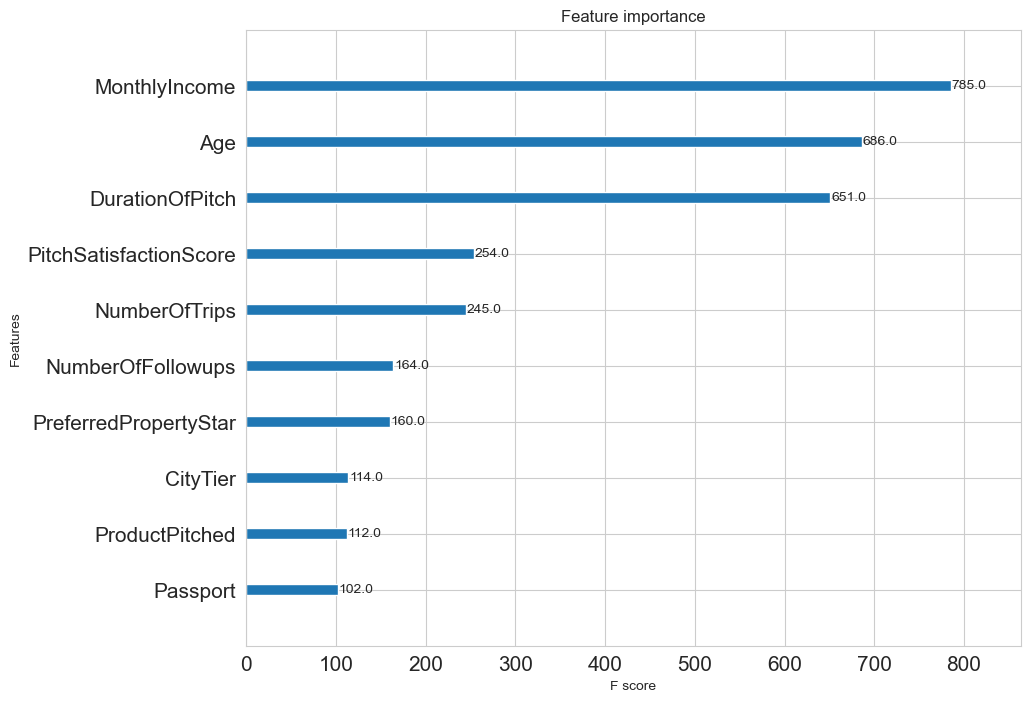

In [10]:
# plot feature importance using XGboost
from numpy import loadtxt
from xgboost import XGBClassifier
from xgboost import plot_importance
from matplotlib import pyplot

# fit model
model = XGBClassifier()
model.fit(X_train, y_train)
# plot feature importance
plot_importance(model)
pyplot.show()

In [11]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,roc_auc_score
from sklearn.model_selection import cross_validate


def eval_classification(model):
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    y_pred_proba = model.predict_proba(X_test)
    y_pred_proba_train = model.predict_proba(X_train)

    print('F1-Score (Test Set) : %.2f' % f1_score(y_test,y_pred))
    print('roc_auc(test_proba) : %.2f' % roc_auc_score(y_test,y_pred_proba[:,1]))
    print('Recall (Test Set) : %.2f' % recall_score(y_test,y_pred))
    print('Accuracy (Test Set) : %.2f' % accuracy_score(y_test,y_pred))
    print('Precicion (Test Set) : %.2f' % precision_score(y_test,y_pred))
    print('Precision (Train Set) : %.2f' % precision_score(y_train,y_pred_train))

# showing importance feature 
def show_feature_importance(model):
    feat_importance = pd.Series(model.feature_importances_,index=X.columns)
    ax = feat_importance.nlargest(25).plot(kind='barh',figsize=(10,8))
    ax.invert_yaxis()

    plt.xlabel('score')
    plt.ylabel('feature')
    plt.title('feature importance score')


def show_best_hyperparameter(model):
    print(model.best_estimator_.get_params())

def eval_clf(model,X_train,y_train,X_test,y_test):
    y_pred = model.predict(X_test)
    y_pred_train = model.predict(X_train)
    y_pred_proba = model.predict_proba(X_test)
    y_pred_proba_train = model.predict_proba(X_train)

    f1 = round(f1_score(y_test,y_pred),3)
    auc_test = round(roc_auc_score(y_test,y_pred_proba[:,1]),3)
    accuracy = round(accuracy_score(y_test,y_pred),3)
    recall = round(recall_score(y_test,y_pred),3)
    precision = round(precision_score(y_test,y_pred),3)
    precision_train = round(precision_score(y_train,y_pred_train),3)

    return f1, auc_test,accuracy,recall,precision,precision_train

def score_all_classification(model_list,X_train,y_train,X_test,y_test) :
    model_name = ['Logistic Regression','KNN','Decision Tree','Random Forest','AdaBoost','XGBoost']
    eval_cols = ['Model','F1 Score','AUC','Accuracy','Recall','Precision (Test)','Precision (Train)']

    eval_list=[]
    for name, model in zip(model_name,model_list):
        result = eval_clf(model,X_train,y_train,X_test,y_test)
        eval_list.append([name] + list(result))

    df_model = pd.DataFrame(data=eval_list,columns=eval_cols)

    return df_model


In [12]:
import numpy as np
from matplotlib import pyplot as pyplot
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

def draw_learning_curve(param_values):
    train_scores = []
    test_scores = []

    for c in param_values:
        model = LogisticRegression(penalty='l2', C=c)
        model.fit(X_train, y_train)

        # eval on train 
        y_pred_train_proba = model.predict_proba(X_train)
        train_auc = roc_auc_score(y_train,y_pred_train_proba[:,1])
        train_scores.append(train_auc)

        # eval on test
        y_pred_proba = model.predict_proba(X_test)
        test_auc = roc_auc_score(y_test,y_pred_proba[:,1])
        test_scores.append(test_auc)

        print('param value : '+str(c)+';train'+ str(train_auc) + '; test:'+str(test_auc))


    plt.plot(param_values,train_scores,label='Train')
    plt.plot(param_values,test_scores,label="Test")
    plt.xlabel('C')
    plt.ylabel('AUC')
    plt.title('Learning Curve - Hyperparameter C - Logistic Regression')
    plt.legend()
    plt.show()

## ***Modelling***

### **Logistic Regression**

In [13]:
#LogisticRegression

from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
logreg.fit(X_train,y_train)
eval_classification(logreg)

F1-Score (Test Set) : 0.47
roc_auc(test_proba) : 0.76
Recall (Test Set) : 0.45
Accuracy (Test Set) : 0.82
Precicion (Test Set) : 0.49
Precision (Train Set) : 0.66


### **KNN**

In [14]:
# KNN

from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_train,y_train)
eval_classification(knn)


F1-Score (Test Set) : 0.56
roc_auc(test_proba) : 0.83
Recall (Test Set) : 0.60
Accuracy (Test Set) : 0.83
Precicion (Test Set) : 0.52
Precision (Train Set) : 0.82


### **Decision Tree**

In [15]:
# decision tree
from sklearn.tree import DecisionTreeClassifier
dt=DecisionTreeClassifier()
dt.fit(X_train,y_train)
eval_classification(dt)

F1-Score (Test Set) : 0.72
roc_auc(test_proba) : 0.83
Recall (Test Set) : 0.74
Accuracy (Test Set) : 0.90
Precicion (Test Set) : 0.70
Precision (Train Set) : 1.00


### **Random Forest Classifier**

In [16]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train,y_train)
eval_classification(rf)

F1-Score (Test Set) : 0.79
roc_auc(test_proba) : 0.94
Recall (Test Set) : 0.72
Accuracy (Test Set) : 0.93
Precicion (Test Set) : 0.87
Precision (Train Set) : 1.00


### **AdaBoost Classifier**

In [17]:
from sklearn.ensemble import AdaBoostClassifier

clf = AdaBoostClassifier()
clf.fit(X_train,y_train)
eval_classification(clf)

F1-Score (Test Set) : 0.48
roc_auc(test_proba) : 0.77
Recall (Test Set) : 0.47
Accuracy (Test Set) : 0.82
Precicion (Test Set) : 0.49
Precision (Train Set) : 0.70


### **XGBoost**

In [18]:
from xgboost import XGBClassifier

xg = XGBClassifier()
xg.fit(X_train,y_train)
eval_classification(xg)

F1-Score (Test Set) : 0.74
roc_auc(test_proba) : 0.92
Recall (Test Set) : 0.68
Accuracy (Test Set) : 0.91
Precicion (Test Set) : 0.80
Precision (Train Set) : 1.00


## ***Model Evaluation***

In [19]:
from sklearn.metrics import precision_score, recall_score,f1_score,roc_auc_score
model_list_base = [logreg,knn,dt,rf,clf,xg]

score_all_classification(model_list_base,x_train,y_train,x_test,y_test)

,Model,F1 Score,AUC,Accuracy,Recall,Precision (Test),Precision (Train)
0,Logistic Regression,0.470,0.760,0.818,0.453,0.487,0.657
1,KNN,0.557,0.834,0.831,0.599,0.521,0.823
2,Decision Tree,0.718,0.834,0.897,0.737,0.700,1.000
3,Random Forest,0.790,0.939,0.932,0.725,0.869,1.000
4,AdaBoost,0.482,0.769,0.819,0.474,0.492,0.698
5,XGBoost,0.740,0.918,0.914,0.684,0.805,1.000


## ***Hyperparameter Tuning***

### **Random Forest Classifier**

***Before Tuning***

In [20]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf.fit(X_train,y_train)
eval_classification(rf)


F1-Score (Test Set) : 0.78
roc_auc(test_proba) : 0.94
Recall (Test Set) : 0.73
Accuracy (Test Set) : 0.93
Precicion (Test Set) : 0.84
Precision (Train Set) : 1.00


***Cross Validation***

In [21]:
# cross validation

from sklearn.model_selection import cross_validate

model = rf
score_rf = cross_validate(model,X,y,cv=5,scoring='precision',return_train_score=True)

print('precision (train) :' + str(score_rf['train_score'].mean()))
print('precision (test) :' + str(round(score_rf['test_score'].mean(),2)))

precision (train) :1.0
precision (test) :0.95


***After Tuning***

In [22]:
rf_tuned = RandomForestClassifier(n_estimators=10,max_depth=28,criterion='entropy',random_state=42)
rf_tuned.fit(X_train,y_train)
eval_classification(rf_tuned)

F1-Score (Test Set) : 0.75
roc_auc(test_proba) : 0.91
Recall (Test Set) : 0.66
Accuracy (Test Set) : 0.92
Precicion (Test Set) : 0.87
Precision (Train Set) : 1.00


***Cross Validation***

In [23]:
from sklearn.model_selection import cross_validate
model = rf_tuned
score_rftuned= cross_validate(model,X,y,cv=5,scoring='precision',return_train_score=True)

print('precision (train) :' + str(round(score_rftuned['train_score'].mean(),4)))
print('precision (test) :' + str(round(score_rftuned['test_score'].mean(),2)))

precision (train) :0.9985
precision (test) :0.94


### **XGBoost**

***Before Tuning***

In [24]:
from xgboost import XGBClassifier
xg = XGBClassifier()
xg.fit(X_train,y_train)
eval_classification(xg)

F1-Score (Test Set) : 0.74
roc_auc(test_proba) : 0.92
Recall (Test Set) : 0.68
Accuracy (Test Set) : 0.91
Precicion (Test Set) : 0.80
Precision (Train Set) : 1.00


***Cross Validation***

In [25]:
from sklearn.model_selection import cross_validate

score_xg = cross_validate(xg,X,y,cv=5,scoring='precision',return_train_score=True)

print('precision (train) :' + str(score_xg['train_score'].mean()))
print('precision (test) :' + str(round(score_xg['test_score'].mean(),2)))


precision (train) :1.0
precision (test) :0.92


***After Tuning***

In [26]:
from xgboost import XGBClassifier

xg_tuned = XGBClassifier(n_estimators=25,max_depth=19,gamma=1,learning_rate = 0.3693877551020408, random_state=42)
xg_tuned.fit(X_train,y_train)
eval_classification(xg_tuned)

F1-Score (Test Set) : 0.78
roc_auc(test_proba) : 0.92
Recall (Test Set) : 0.72
Accuracy (Test Set) : 0.93
Precicion (Test Set) : 0.86
Precision (Train Set) : 1.00


***Cross Validation***

In [27]:
from sklearn.model_selection import cross_validate
score_xgtuned = cross_validate(xg_tuned,X,y,cv=5,scoring='precision',return_train_score=True)

print('precision (train) :'+str(round(score_xgtuned['train_score'].mean(),3)))
print('precision (test) :'+str(round(score_xgtuned['test_score'].mean(),3)))


precision (train) :0.999
precision (test) :0.915


## **Cross Validation Model Evaluation**

In [28]:
eval_cols =['Model','Precision (Test)','Precision (Train)']
model_name = ['Random Forest','XGBoost']

test = [round(float(score_rftuned['test_score'].mean()),3),round(float(score_xgtuned['test_score'].mean()),3)]
train = [round(float(score_rftuned['train_score'].mean()),3),round(float(score_xgtuned['train_score'].mean()),3)]

df_cvmodel = pd.DataFrame(list(zip(model_name,test,train)),columns=eval_cols)
df_cvmodel

,Model,Precision (Test),Precision (Train)
0,Random Forest,0.940,0.999
1,XGBoost,0.915,0.999


### **Feature Importance** ***after Hyperparameter Tuning***

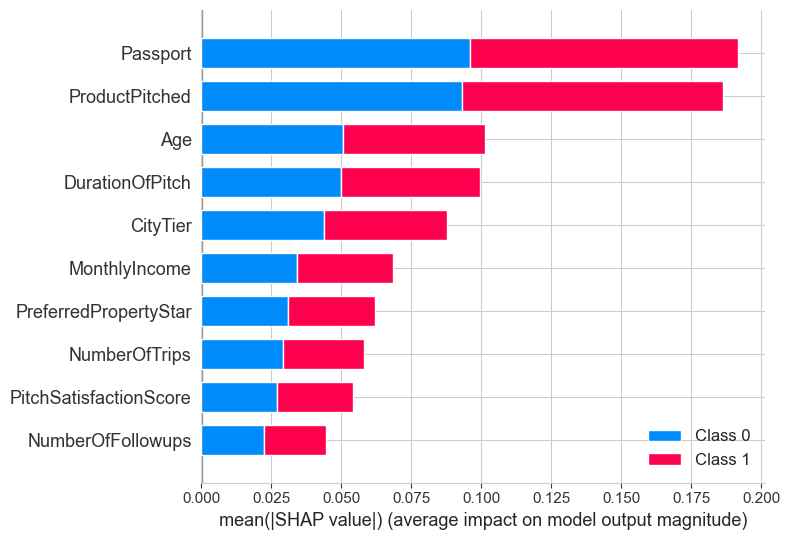

In [29]:
import shap
explaine = shap.TreeExplainer(rf_tuned)
shap_values = explaine.shap_values(X_test)

shap.summary_plot(shap_values,X_test)

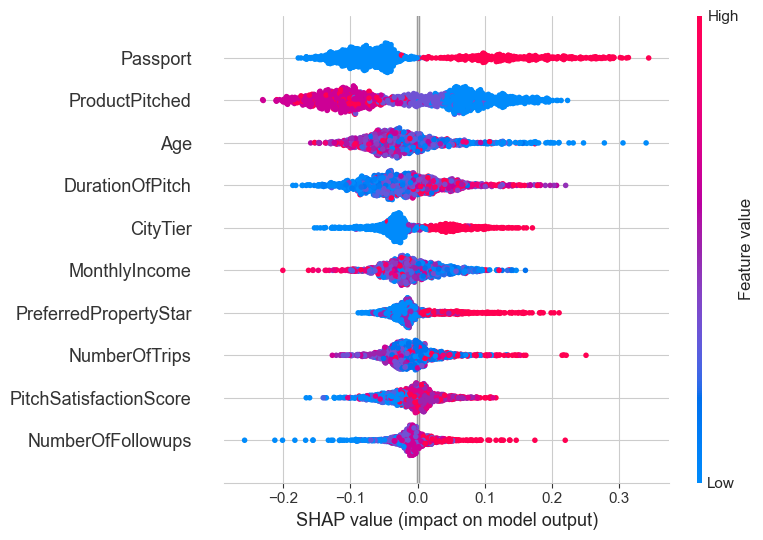

In [30]:
shap.summary_plot(shap_values[1],X_test)
